In [1]:
!pip install langchain langgraph openai -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.9/309.9 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 14.3 MB/s eta 0:00:00


In [62]:
from typing import Dict, TypedDict, Optional
from langgraph.graph import StateGraph, END
import os
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

In [63]:
from google.colab import userdata
os.environ['OPENAI_API_KEY']=userdata.get('OPENAI_API_KEY')

In [64]:
class GraphState(TypedDict):
    question: Optional[str] = None
    classification: Optional[str] = None
    response: Optional[str] = None

In [65]:
workflow = StateGraph(GraphState)

In [66]:
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "classify the intent of given query as greeting or not_greeting. Output just the class.",
        ),
        ("human", "{question}"),
    ]
)

chain = prompt | llm


In [67]:
def classify(question):

  result = chain.invoke(
      {
          "question": question
      }
  )
  return result.content

In [68]:
def classify_input_node(state):
  question = state.get('question','').strip()
  classification = classify(question)
  return {"classification": classification}

In [69]:
def handle_greeting_node(state):
  return {"response": "Hello how can I help you today?"}

In [70]:
def handle_llm(state):
  question = state.get('question','').strip()
  return {"response": llm.invoke(question).content}

In [71]:
def bye(state):
  current_response = state.get('response')
  return {"response": current_response + ". The graph has finished"}

In [72]:
workflow.add_node("classify_input", classify_input_node)
workflow.add_node("handle_greeting", handle_greeting_node)
workflow.add_node("handle_llm", handle_llm)
workflow.add_node("bye", bye)


In [73]:
workflow.set_entry_point("classify_input")
workflow.add_edge("handle_greeting", END)
workflow.add_edge("handle_llm", "bye")
workflow.add_edge("bye", END)

In [74]:
def decide_next_node(state):
  return "handle_greeting" if state.get("classification") == "greeting" else "handle_llm"

In [75]:
workflow.add_conditional_edges(
    "classify_input",
    decide_next_node,
     {
        "handle_greeting": "handle_greeting",
        "handle_llm": "handle_llm"
    }
)

In [76]:
app = workflow.compile()

In [77]:
app.invoke({"question": "my name is khan"})

{'question': 'my name is khan',
 'classification': 'not_greeting',
 'response': 'Hello Khan, nice to meet you! How can I assist you today?. The graph has finished'}

In [78]:
app.invoke({"question": "Hello mate, Good Morning"})

{'question': 'Hello mate, Good Morning',
 'classification': 'greeting',
 'response': 'Hello how can I help you today?'}

In [ ]:
# !apt install libgraphviz-dev
# !pip install pygraphviz

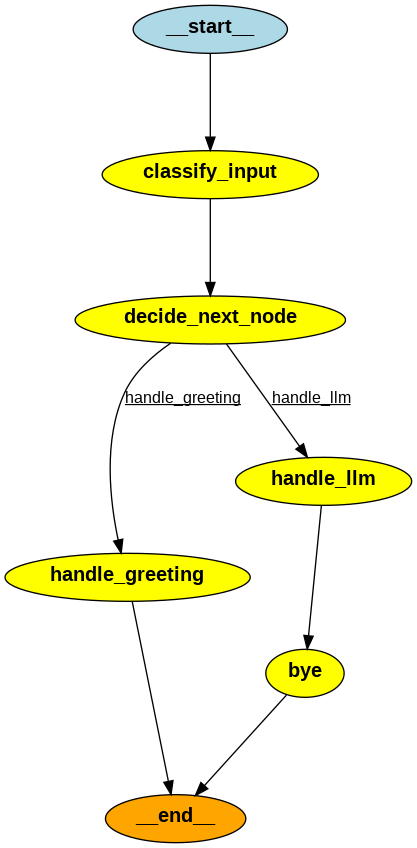

In [82]:
from IPython.display import Image

Image(app.get_graph().draw_png())

In [ ]:
# !pip install grandalf

In [85]:
app.get_graph().print_ascii()

           +-----------+               
           | __start__ |               
           +-----------+               
                  *                    
                  *                    
                  *                    
        +----------------+             
        | classify_input |             
        +----------------+             
                  *                    
                  *                    
                  *                    
        +------------------+           
        | decide_next_node |           
        +------------------+           
            **        **               
          **            **             
         *                **           
+------------+              *          
| handle_llm |              *          
+------------+              *          
       *                    *          
       *                    *          
       *                    *          
    +-----+       +-----------------+  
